# This code applies a threshold to the log of the summed amplitudes across a bandpass filtered .wav file recording to detect song

### apply the full pipeline to ONE recording file

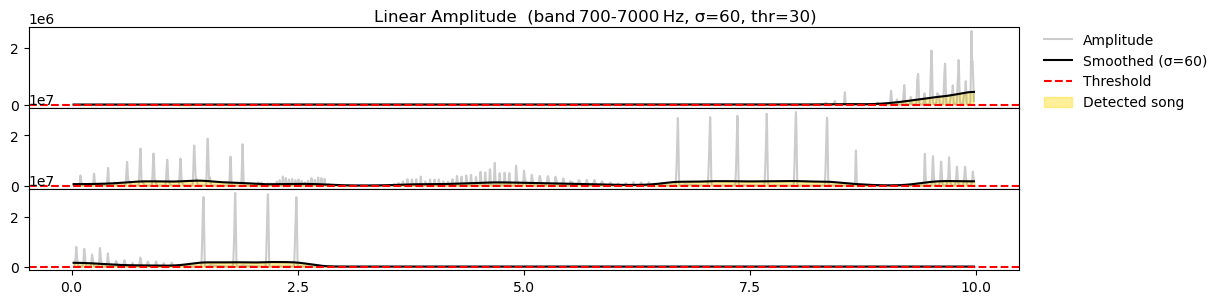

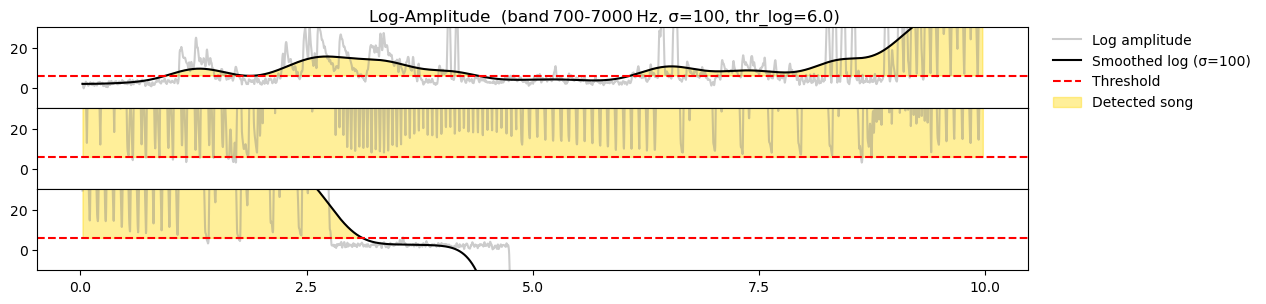

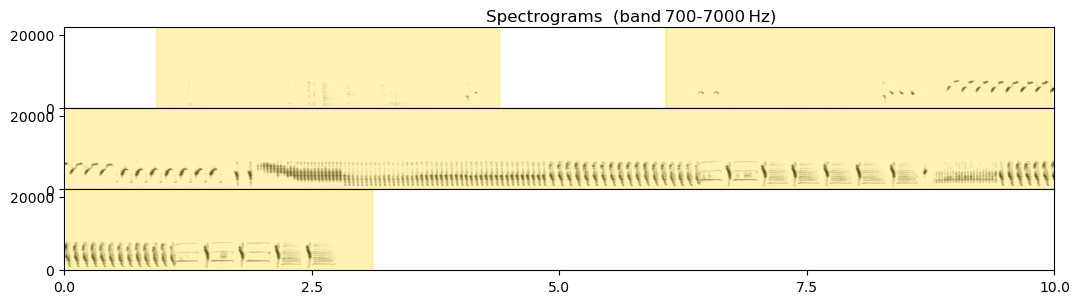


Detected song intervals (s):
      0.94 –     4.40
      6.07 –     9.97
     10.02 –    19.97
     20.02 –    23.12


In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ------------------------------------------------------------
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, height_inches = get_screen_resolution()

# ------------------------------------------------------------
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05,
        sigma_log: Optional[float] = None,
        threshold_log: Optional[float] = None,
        log_base: float = 10
    ) -> List[Tuple[float, float]]:

    if sigma_log is None:
        sigma_log = sigma
    eps = np.finfo(float).eps

    # ---------- Load & band‑pass filter ----------
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ---------- Segment bookkeeping ----------
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ---------- Figure stacks (no vertical spacing) ----------
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig2, axs_log = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig3, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    if n_seg == 1:
        axs_lin, axs_log, axs_spc = [axs_lin], [axs_log], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ---------- Per‑segment processing ----------
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # Spectrogram
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # Linear & log amplitude
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)
        amp_s = gaussian_filter1d(amp, sigma=sigma)
        mask_lin = amp_s > threshold

        amp_log = 10 * np.log10(amp + eps) if log_base == 10 else np.log(amp + eps)
        amp_log_s = gaussian_filter1d(amp_log, sigma=sigma_log)
        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_s, 90)
        mask_log = amp_log_s > threshold_log

        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # ---- Linear amplitude plot ----
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.4,
                 label='Amplitude' if i == 0 else None)
        axL.plot(t, amp_s, color='black',
                 label=f'Smoothed (σ={sigma})' if i == 0 else None)
        axL.axhline(threshold, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axL.fill_between(t, amp_s, threshold, where=mask_lin,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), borderaxespad=0, frameon=False)

        # ---- Log amplitude plot ----
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.4,
                  label='Log amplitude' if i == 0 else None)
        axLg.plot(t, amp_log_s, color='black',
                  label=f'Smoothed log (σ={sigma_log})' if i == 0 else None)
        axLg.axhline(threshold_log, color='red', ls='--',
                     label='Threshold' if i == 0 else None)
        axLg.fill_between(t, amp_log_s, threshold_log, where=mask_log,
                          color='gold', alpha=0.4,
                          label='Detected song' if i == 0 else None)
        axLg.set_ylim(-10, 30)
        axLg.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02, 1.0), borderaxespad=0, frameon=False)

        # ---- Spectrogram plot ----
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # ---------- Titles & final layout ----------
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp}, σ={sigma}, thr={threshold})', fontsize=12)
    fig2.suptitle(f'Log‑Amplitude  (band {bp}, σ={sigma_log}, thr_log={threshold_log:.1f})',
                  fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)
    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)  # room for legends

    plt.show()

    # ---------- Console output ----------
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ------------------------------------------------------------
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=60,
            threshold=30,
            sigma_log=100,
            threshold_log=6     # dB
        )
    else:
        print("Example WAV not found:", wav_path)


## Apply the log-amplitude song detector to a folder of .wav files, then save the file name and detected song segments into a .json file:

In [2]:
#!/usr/bin/env python
"""
Batch long‑amplitude song detector
----------------------------------
Point this at a directory full of .wav files and it will create
<folder_name>_longamp_detected_song_intervals.json
next to that directory.

JSON schema (per file) – same as before:
{
    "example.wav": [
        [start_s0, end_s0],
        [start_s1, end_s1],
        ...
    ],
    ...
}
Detection logic is identical to the “log‑amplitude + smoothing +
threshold” pipeline you used in `plot_spectrograms_by_segment`, but
runs head‑less (no figures).
"""
from __future__ import annotations

import json
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict, Union

from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d


# --------------------------------------------------------------------
# Helpers
# --------------------------------------------------------------------
def mask_to_intervals(
    mask: np.ndarray,
    times: np.ndarray,
    t_offset: float,
) -> List[Tuple[float, float]]:
    """Boolean vector → list of [start, end] (adds constant t_offset)."""
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals


# --------------------------------------------------------------------
# Core detector  (long‑amplitude log‑domain)
# --------------------------------------------------------------------
def detect_song_intervals_longamp(
    file_path: Union[str, Path],
    *,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: float | None = 6.0,        # dB above floor
    log_base: float = 10,
) -> List[Tuple[float, float]]:
    """
    Return a list of (start, end) seconds where log‑amplitude envelope
    exceeds `threshold_log`.

    Parameters
    ----------
    segment_duration : float
        Length (s) of chunks analysed independently. Keeps RAM usage low
        and matches the behaviour of your plotting code.
    sigma_log : float
        Gaussian σ in spectrogram *frames* used to smooth the
        log‑amplitude trace.
    threshold_log : float | None
        Absolute threshold in dB (base‑10) **after** smoothing.  
        If None, it is set to the 90th percentile of the very first
        segment, mimicking your interactive version.
    """
    file_path = Path(file_path)
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:                       # stereo → mono
        data = data.mean(axis=1)

    # --- band‑pass filter (zero‑phase) ---------------------------
    nyq = sr / 2
    wp = [bandpass_filter_low_cut / nyq,
          bandpass_filter_high_cut / nyq]
    b, a = ellip(5, 0.2, 40, wp, btype="band")
    data = filtfilt(b, a, data)

    # --- per‑segment spectrogram analysis ------------------------
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))
    eps     = np.finfo(float).eps
    detected: List[Tuple[float, float]] = []

    for i in range(n_seg):
        # slice with zero‑padding at end of file
        seg = np.zeros(seg_len, dtype=float)
        start = i * seg_len
        seg[: max(0, min(seg_len, len(data) - start))] = data[start : start + seg_len]

        # spectrogram
        f, t, Sxx = spectrogram(
            seg,
            fs=sr,
            window=windows.gaussian(2048, 2048 / 8),
            nperseg=2048,
            noverlap=2048 - 119,
        )

        # amplitude in the pass‑band
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp  = np.sum(Sxx[rows, :], axis=0)

        # log envelope → smooth
        amp_log   = (10 * np.log10(amp + eps)) if log_base == 10 else np.log(amp + eps)
        amp_log_s = gaussian_filter1d(amp_log, sigma=sigma_log)

        # automatic threshold if needed (match your GUI behaviour)
        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_s, 90)

        mask_log = amp_log_s > threshold_log

        # convert to global‑time intervals
        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

    return detected


# --------------------------------------------------------------------
# Batch driver
# --------------------------------------------------------------------
def process_folder(
    folder_path: Union[str, Path],
    *,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: float | None = 6.0,
    log_base: float = 10,
    overwrite: bool = True,
) -> Path:
    """
    Detect song in every .wav in `folder_path` and dump JSON.

    Returns
    -------
    Path  – full path of the JSON file written.
    """
    folder_path = Path(folder_path).expanduser().resolve()
    assert folder_path.is_dir(), f"{folder_path} is not a directory"

    json_path = folder_path.with_suffix("")               # drop trailing “/”
    json_path = json_path.parent / f"{json_path.name}_longamp_detected_song_intervals.json"

    if json_path.exists() and not overwrite:
        raise FileExistsError(f"{json_path} already exists (use overwrite=True to replace)")

    wav_files = sorted(folder_path.glob("*.wav"))
    print(f"📂 Processing {len(wav_files)} .wav files in: {folder_path}")

    results: Dict[str, List[List[float]]] = {}

    for wav in wav_files:
        intervals = detect_song_intervals_longamp(
            wav,
            segment_duration=segment_duration,
            bandpass_filter_low_cut=bandpass_filter_low_cut,
            bandpass_filter_high_cut=bandpass_filter_high_cut,
            sigma_log=sigma_log,
            threshold_log=threshold_log,
            log_base=log_base,
        )

        icon = "🎵" if intervals else "⚪"
        print(f"{icon} {wav.name:<45} {len(intervals)} segment{'s' if len(intervals)!=1 else ''}")

        # tuples → lists so json is valid
        results[wav.name] = [list(iv) for iv in intervals]

    with open(json_path, "w") as fp:
        json.dump(results, fp, indent=4)

    print(f"\n✅ Saved results to {json_path}")
    return json_path


# --------------------------------------------------------------------
# Example CLI usage
# --------------------------------------------------------------------
if __name__ == "__main__":
    # EDIT this to point at your folder of WAVs
    folder = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files"

    # tweak parameters as needed
    process_folder(
        folder,
        segment_duration=10,
        bandpass_filter_low_cut=700,
        bandpass_filter_high_cut=7000,
        sigma_log=100,
        threshold_log=6.0,        # dB
    )

📂 Processing 5 .wav files in: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files
🎵 USA5510_45755.26006037_4_8_7_13_26.wav        5 segments
🎵 USA5510_45755.26030477_4_8_7_13_50.wav        2 segments
🎵 USA5510_45755.26071817_4_8_7_14_31.wav        3 segments
⚪ USA5510_45755.26110762_4_8_7_15_10.wav        0 segments
⚪ USA5510_45755.26270678_4_8_7_17_50.wav        0 segments

✅ Saved results to /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files_longamp_detected_song_intervals.json


## Optional: Combine detected songs that are less than 2 seconds away from each other:

In [4]:
import json
from pathlib import Path

# ------------------------------------------------------------
# CONFIG – detector JSON and merge gap
# ------------------------------------------------------------
#json_path = Path(
#   "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files_amplitude_only_detected_song_intervals.json"
#).expanduser().resolve()
json_path = Path(
  folder + "_longamp_detected_song_intervals.json"
).expanduser().resolve()
merge_gap = 2.0          # seconds between intervals to weld
assert json_path.is_file(), f"Cannot find {json_path}"
print(f"Loading intervals from: {json_path}")

# ------------------------------------------------------------
# Helper – merge one file’s intervals
# ------------------------------------------------------------
def merge_intervals(intervals, gap=1.0):
    """Merge adjacent intervals whose silence ≤ gap seconds."""
    if not intervals:
        return []

    merged = []
    cur_start, cur_end = intervals[0]

    for start, end in intervals[1:]:
        if start - cur_end <= gap:       # extend current span
            cur_end = max(cur_end, end)
        else:                            # push & start new span
            merged.append([cur_start, cur_end])
            cur_start, cur_end = start, end

    merged.append([cur_start, cur_end])
    return merged

# ------------------------------------------------------------
# Load → merge → build new dict
# ------------------------------------------------------------
with open(json_path) as f:
    interval_dict = json.load(f)

combined_dict = {
    fname: merge_intervals(sorted(intervals, key=lambda x: x[0]), gap=merge_gap)
    for fname, intervals in interval_dict.items()
}

# ------------------------------------------------------------
# Pretty print summary
# ------------------------------------------------------------
print("\nSummary (after merging):\n")
for fname in sorted(combined_dict):
    seg_count = len(combined_dict[fname])
    icon = "🎵" if seg_count else "⚪"
    print(f"  {icon} {fname:<45} {seg_count:2d} segments")

# ------------------------------------------------------------
# Save combined file
# ------------------------------------------------------------
out_path = json_path.with_name("logamp_combined_song_intervals.json")
with open(out_path, "w") as f:
    json.dump(combined_dict, f, indent=4)

print(f"\n✅  Combined intervals saved → {out_path}")


Loading intervals from: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/sample_wav_files_longamp_detected_song_intervals.json

Summary (after merging):

  🎵 USA5510_45755.26006037_4_8_7_13_26.wav         2 segments
  🎵 USA5510_45755.26030477_4_8_7_13_50.wav         1 segments
  🎵 USA5510_45755.26071817_4_8_7_14_31.wav         1 segments
  ⚪ USA5510_45755.26110762_4_8_7_15_10.wav         0 segments
  ⚪ USA5510_45755.26270678_4_8_7_17_50.wav         0 segments

✅  Combined intervals saved → /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_debug_segmenter/logamp_combined_song_intervals.json
